In [12]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n):
    x = np.random.uniform(-3, 3, n)
    y = np.sin(x) + np.exp(-np.abs(x)) * np.random.normal(0, 1, n)
    return x, y

n_train, n_cal, n_test = 5000, 1000, 1000
X_train, y_train = generate_data(n_train)
X_cal, y_cal = generate_data(n_cal)
X_test, y_test = generate_data(n_test)

Conformal inference is a model-free, distribution-free, nonasymptotic technique for constructing prediction intervals with statistical coverage guarantees. *Split conformal inference* does the following:

1) Fit a regression model $\hat{f}$ on the training data.
2) Use a heldout calibration set $\{(x_i,y_i)\}_{i=1}^n$ to quantify the uncertainty in $\hat{f}$'s predictions. Specifically:

   a) Compute the score $s_i=|y_i-\hat{f}(x_i)|$ for each $(x_i, y_i)$ in the calibration set; this quantifies the extent to which the prediction $\hat{f}(x_i)$ "conforms" to the true $y_i$.
   
   b) Set $\tau$ to be the upper $\left\lceil\frac{(n+1)( 1-\alpha)}{n}\right\rceil$ quantile of the scores.
   
   c) Generate the prediction interval $\hat{C}(x')=[\hat{f}(x')-\tau,\ \hat{f}(x')+\tau]$. We are guaranteed that $P(y'\in\hat{C}(x'))\geq 1-\alpha.$

Empirical coverage: 0.8970


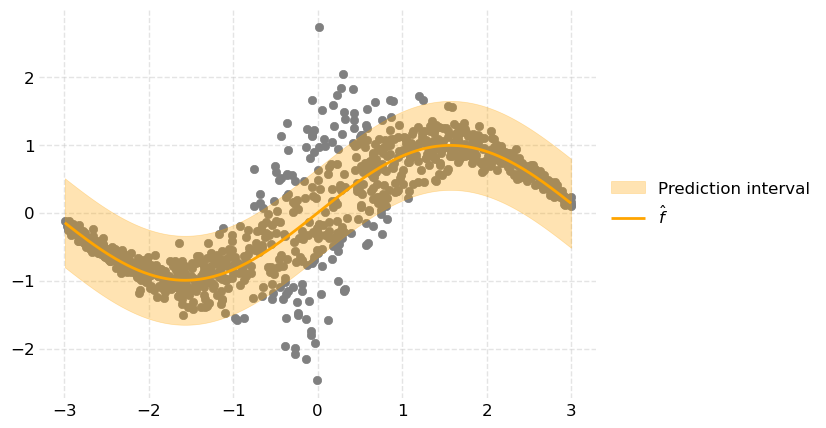

In [13]:
alpha = 0.1

# fit OLS model
b_OLS = (np.sin(X_train).T @ y_train) / np.sum(np.sin(X_train)**2)

# calibrate OLS model
s_OLS = np.abs(np.sin(X_cal) * b_OLS - y_cal)
tau_OLS = np.quantile(s_OLS, np.ceil((n_cal+1)*(1-alpha))/n_cal, interpolation='higher')

# evaluate coverage of conformal OLS
y_hat = np.sin(X_test) * b_OLS
interval_OLS = (y_hat - tau_OLS, y_hat + tau_OLS)
coverage_OLS = np.mean((interval_OLS[0] <= y_test) & (y_test <= interval_OLS[1]))
print(f"Empirical coverage: {coverage_OLS:.4f}")

# plot coverage
plt.scatter(X_test, y_test, c='grey')
idx = np.argsort(X_test)
plt.fill_between(X_test[idx], interval_OLS[0][idx], interval_OLS[1][idx], alpha=0.3, label='Prediction interval', color='orange')
plt.plot(X_test[idx], y_hat[idx], c='orange', label=r"$\hat{f}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Notably, this is a marginal guarantee on $P(y'\in\hat{C}(x'))$, *not* on the conditional $P(y'\in\hat{C}(x')|x').$ Since the prediction interval's width is constant ($2\tau$) regardless of the value of $x'$, this means that conformal inference tends to overcover in low-variance regions and undercover in high-variance regions (see above).

*Conformalized quantile regression* (CQR) uses quantile regression to generate prediction intervals of variable width:

1) Fit two regression models, $\hat{f}_{\alpha/2}$ and $\hat{f}_{1-\alpha/2}$, to predict the conditional $\alpha/2$ and $1-\alpha/2$ quantiles.
2) Compute the score $s_i=\mathrm{max}\big(\hat{f}_{\alpha/2}(x_i)-y, y-\hat{f}_{1-\alpha/2}(x_i)\big)$ for each $(x_i, y_i)$ in the calibration set $\{(x_i,y_i)\}_{i=1}^n$.
3) Set $\tau$ to be the upper $\left\lceil\frac{(n+1)( 1-\alpha)}{n}\right\rceil$ quantile of the scores.
4) Generate the prediction interval $\hat{C}(x')=[\hat{f}_{\alpha/2}(x')-\tau,\ \hat{f}_{1-\alpha/2}(x')+\tau]$. We are guaranteed that $P(y'\in\hat{C}(x'))\geq 1-\alpha.$

In [14]:
import torch
import torch.nn as nn

class QuantileRegressionNN(nn.Module):
    def __init__(self, h1, h2):
        super(QuantileRegressionNN, self).__init__()
        self.fc1 = nn.Linear(1, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.lower = nn.Linear(h2, 1)
        self.upper = nn.Linear(h2, 1)

    def forward(self, x):
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        return self.lower(x), self.upper(x)

def quantile_loss(y, l_hat, u_hat, alpha):
    l_resid, u_resid = y - l_hat, y - u_hat
    l_loss = torch.mean(torch.max((alpha - 1) * l_resid, alpha * l_resid))
    u_loss = torch.mean(torch.max(((1-alpha) - 1) * u_resid, (1-alpha) * u_resid))
    return l_loss + u_loss

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:52<00:00, 95.78it/s] 


Emperical CQR coverage: 0.8920


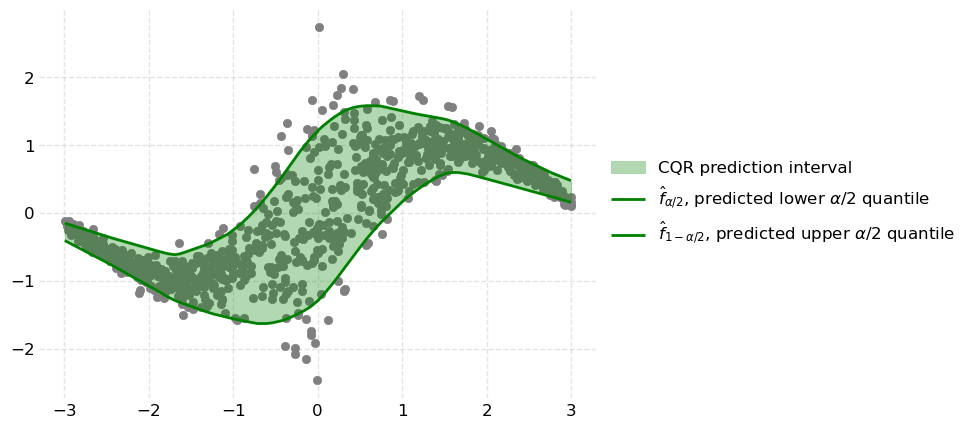

In [16]:
import torch.optim as optim
from tqdm import tqdm

# fit quantile regression model
X_train_tensor = torch.tensor(X_train[:,None], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[:,None], dtype=torch.float32)
qreg = QuantileRegressionNN(128, 128)
optimizer = optim.SGD(qreg.parameters(), lr=0.01)
for epoch in tqdm(range(5000)):
    lower, upper = qreg(X_train_tensor)
    loss = quantile_loss(y_train_tensor, lower, upper, alpha/2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
# calibrate quantile regression model
X_cal_tensor = torch.tensor(X_cal[:,None], dtype=torch.float32)
lower_cal, upper_cal = qreg(X_cal_tensor)
s_qreg = np.maximum(
    lower_cal.detach().numpy().squeeze()  - y_cal,
    y_cal - upper_cal.detach().numpy().squeeze()
)
tau_CQR = np.quantile(s_qreg, np.ceil((n_cal+1)*(1-alpha))/n_cal, interpolation='higher')

# evaluate coverage for CQR
X_test_tensor = torch.tensor(X_test[:,None], dtype=torch.float32)
lower_test, upper_test = qreg(X_test_tensor)
lower_test = lower_test.detach().numpy().squeeze()
upper_test = upper_test.detach().numpy().squeeze()
interval_CQR = (lower_test - tau_CQR, upper_test + tau_CQR)
coverage_CQR = np.mean((interval_CQR[0] <= y_test) & (y_test <= interval_CQR[1]))
print(f"Emperical CQR coverage: {coverage_CQR:.4f}")

# plot coverage
plt.scatter(X_test, y_test, color='grey')
idx = np.argsort(X_test)
plt.fill_between(X_test[idx], interval_CQR[0][idx], interval_CQR[1][idx], alpha=0.3, label='CQR prediction interval', color='green')
plt.plot(X_test[idx], lower_test[idx], label=r'$\hat{f}_{\alpha/2}$, predicted lower $\alpha/2$ quantile', color='green')
plt.plot(X_test[idx], upper_test[idx], label=r'$\hat{f}_{1-\alpha/2}$, predicted upper $\alpha/2$ quantile', color='green')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()